In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import ext_transforms as et #augmentation library from gongfan fang (https://github.com/VainF/DeepLabV3Plus-Pytorch)
from dataset import SatelliteDataset
from torch.utils.data import DataLoader

In [2]:
train_transform = et.ExtCompose([
    et.ExtRandomCrop(size=(128,128)),
    et.ExtColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    et.ExtRandomHorizontalFlip(),
    et.ExtToTensor(),
    et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

In [3]:
dataset = SatelliteDataset(image_dir='train_images', mask_dir='masks', transform=train_transform)

In [4]:
#split train data in train and val
train_set, val_set = torch.utils.data.random_split(dataset, lengths=[0.9, 0.1])

In [5]:
#use predefined deeplabv3 with mobilenet backbone
#model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(num_classes=1)

In [6]:
#use predefined deeplabv3 with resnet50 backbone
model = torchvision.models.segmentation.deeplabv3_resnet50(num_classes=1)

In [8]:
train_loader = DataLoader(train_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2)

In [9]:
epochs = 1000

In [10]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=3e-3)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer=optimizer, power=0.9 ,total_iters=epochs)

In [11]:
def validate(model, loader):
    model.eval()
    for image, mask in loader:
        image = image.to(dtype=torch.float32)
        mask = mask.to(dtype=torch.float32)/255
        output = model(image)['out']
        loss = loss_fn(output, mask)
    return loss.item()

In [ ]:
train_loss = []
val_loss = []
best_val_loss = 10 # some arbitrary number for init
for i in range(epochs):
    count = 0
    running_loss = 0
    for image, mask in train_loader:
        model.train()
        optimizer.zero_grad()
        
        image = image.to(dtype=torch.float32)
        mask = mask.to(dtype=torch.float32)/255

        output = model(image)['out']

        loss = loss_fn(output, mask)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        count += 1
    scheduler.step()

    #statistics
    train_loss.append(running_loss/count)
    current_val_loss = validate(model,val_loader)
    if current_val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_resnet_model')
        best_val_loss = current_val_loss
    val_loss.append(current_val_loss)
    print('epoch: ', i + 1, ' | avg train loss: ', running_loss/count, ' | val loss: ', current_val_loss)

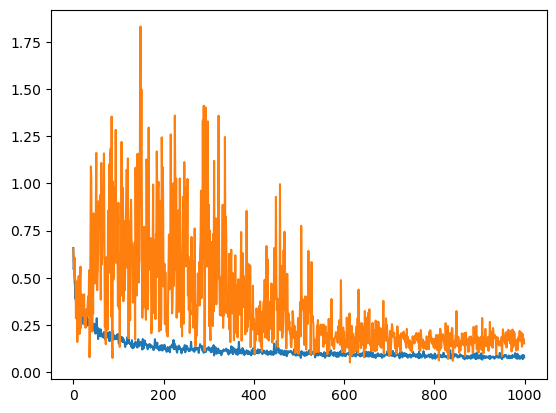

In [11]:
plt.plot(train_loss)
plt.plot(val_loss)